# Spatial Point Pattern Analysis of Flood Complaints in Miami, Florida

Hailun Ma

# Abstract

This project analyzes the spatial pattern of flood-related 311 complaints in Miami. Using point data from the City of Miami and elevation data from USGS, I explore whether these complaints are randomly distributed or if they form clusters across the city. After building exploratory maps, kernel density estimates, and conducting formal spatial tests including Ripley’s K-function and the Pair Correlation Function, the results show strong evidence of clustering. These findings suggest that certain neighborhoods consistently experience more flood issues, likely due to local infrastructure, elevation, and drainage conditions.

# Introduction

Urban flooding is a recurring problem in Miami, especially during heavy rainfall and king tide events. Residents often submit 311 complaints when streets or properties flood, which creates a useful dataset for understanding where flooding tends to happen. In this project, I focus on flood-related 311 complaints to answer a simple question:

**Are Miami’s flood complaints randomly distributed across the city, or do they form clusters in specific neighborhoods?**

To answer this, I use several tools from spatial data science, including exploratory mapping, kernel density estimation, and formal second-order spatial statistics.  
These methods allow me to evaluate both the overall intensity of the events and the underlying spatial interaction between points. The goal is to understand whether the pattern reflects random noise or meaningful spatial structure.

------------------------------------------------------------------------

# Literature Review

Flooding patterns in coastal cities often reflect a combination of environmental conditions (such as elevation and proximity to the coastline) and built infrastructure (storm drains, road design, land cover). Prior research shows that:

-   Low elevations and tidal influences increase vulnerability.  
-   Urban hydrology can produce recurring flood “hotspots.”  
-   Spatial point pattern methods, including K-function and PCF, are widely used for identifying clustering in crime, disease, and environmental hazards.

However, fewer studies examine **urban flood complaints** using these methods, even though 311 data provide highly localized, real-time information. This project adds to the literature by applying spatial statistics to understand Miami’s flood experience from the perspective of residents.

------------------------------------------------------------------------

# Data

This project uses two main datasets:

1.  **311 flood-related complaints in Miami (CSV)**  
    The dataset includes the location of each complaint (longitude and latitude), the type of issue, a short description, and the date the ticket was created.  
    I cleaned the dataset by selecting only complaints related to flooding and by converting the coordinates into a projected CRS (EPSG:3857) for spatial analysis.

2.  **USGS Digital Elevation Model (GeoTIFF)**  
    Elevation is used to understand the terrain and visually compare low-lying regions with clusters of complaints. The raster was reprojected and plotted together with the complaint points.

Together, these datasets allow both first-order (intensity-based) and second-order (interaction-based) spatial analysis.

# Methods

### Exploratory Mapping

I first plotted the raw points to get a general sense of where complaints occur.  
I also created an interactive map and a heatmap, which both suggested that the complaints concentrate around the Coral Gables–Miami Beach area.

### Kernel Density Estimation (First-order Analysis)

I used a kernel density estimate (KDE) to examine the intensity of events across Miami. This shows where complaints are more frequent without making any assumptions about spatial interaction.

### Ripley’s K-function (Second-order Analysis)

To formally test whether the pattern is clustered or random, I computed Ripley’s K-function and compared it to 999 simulated patterns generated under the assumption of Complete Spatial Randomness (CSR).  
If the observed curve is above the CSR envelope, this indicates clustering.

### Pair Correlation Function

The PCF is a related second-order tool that focuses specifically on short-range interactions. It is especially helpful for detecting clustering within the first few hundred meters. Like the K-function, I generated 999 simulations to form a CSR envelope for comparison.

In [ ]:
library(readr)
library(dplyr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Linking to GEOS 3.12.1, GDAL 3.8.4, PROJ 9.4.0; sf_use_s2() is TRUE

terra 1.8.60

Loading required package: spatstat.data

Loading required package: spatstat.univar

spatstat.univar 3.1-5

spatstat.geom 3.6-1


Attaching package: 'spatstat.geom'

The following objects are masked from 'package:terra':

    area, delaunay, is.empty, rescale, rotate, shift, where.max,
    where.min

Loading required package: spatstat.random

spatstat.random 3.4-3

Loading required package: nlme


Attaching package: 'nlme'

The following object is masked from 'package:dplyr':

    collapse

spatstat.explore 3.6-0


Attaching package: 'MASS'

The following object is masked from 'package:spatstat.geom':

    area

The following object is masked from 'package:terra':

    area

The following object is masked from 'package:dplyr':

    select

Rows: 2891 Columns: 5

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): issue_type, issue_Description, ticket_created_date_time
dbl (2): longitude, latitude

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 2,891
Columns: 5
$ longitude                <dbl> -8932290, -8926399, -8928695, -8925170, -8928…
$ latitude                 <dbl> 2972113, 2974227, 2972024, 2980140, 2977474, …
$ issue_type               <chr> "COMPWSF", "COMPWSF", "COMPWSF", "COMPWSF", "…
$ issue_Description        <chr> "STORM FLOOD/ DRAINAGE", "STORM FLOOD/ DRAINA…
$ ticket_created_date_time <chr> "2022/10/07 13:11:03.294+00", "2022/10/01 15:…

### Figure 1. Study Area Map (Boundary + Points)

Rows: 2891 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): issue_type, issue_Description, ticket_created_date_time
dbl (2): longitude, latitude

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

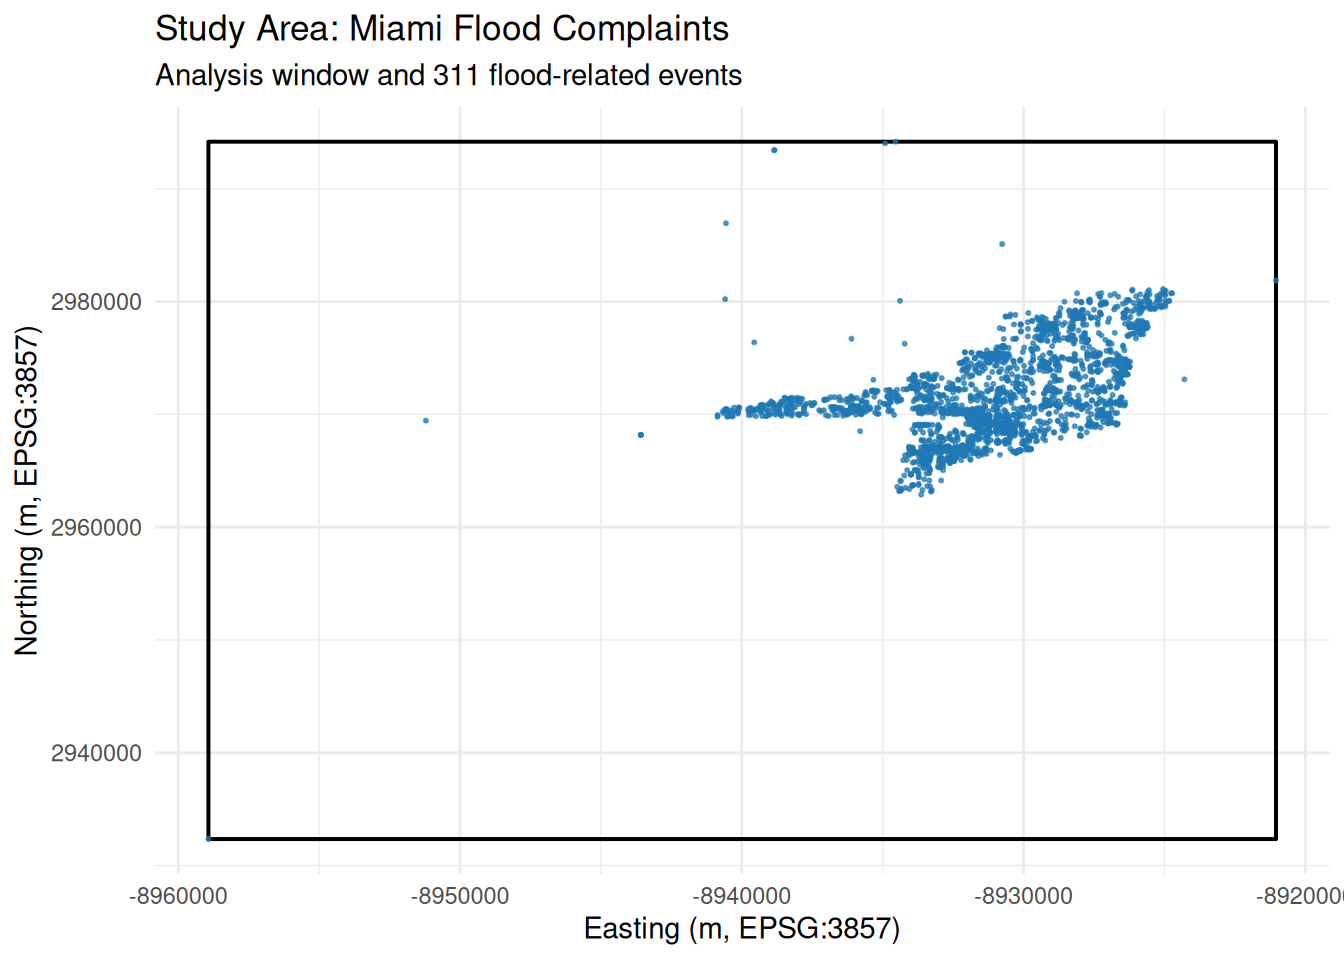

In [ ]:
library(readr)
library(sf)
library(ggplot2)
library(dplyr)

flood_events <- read_csv("output_data/flood_events_miami.csv")

## Elevation Context (First-Order Pattern)

Understanding whether flood-related 311 complaints occur preferentially in low-lying areas is a first-order spatial question. To explore this, elevation data for Miami (USGS DEM) were visualized alongside the point pattern of flood complaints. If lower-elevation zones show visibly higher concentrations of points, this would provide initial evidence of an underlying first-order intensity gradient driven by topography.

### Figure 2. Elevation Raster Overlaid with Flood Complaints

Areas of lower elevation appear to contain denser clusters of flood-related complaints. This visual pattern suggests the possibility of a first-order intensity variation driven by elevation, which motivates the formal hypothesis-testing steps that follow.

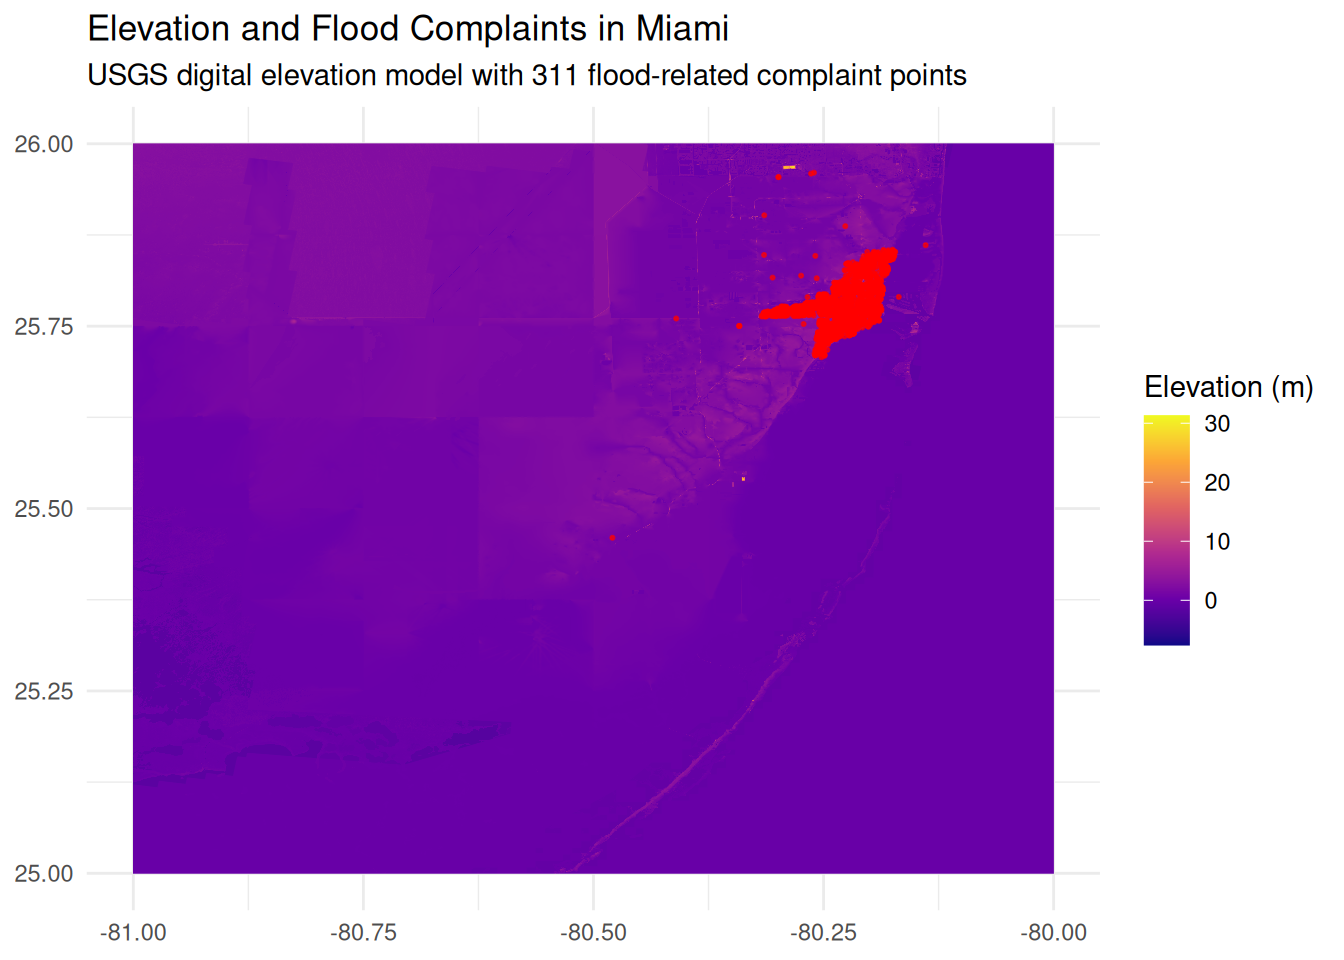

In [ ]:
library(terra)
library(sf)
library(ggplot2)
library(dplyr)

dem <- rast("output_data/miami_florida.tif")

dem_df <- as.data.frame(dem, xy = TRUE, na.rm = TRUE)
names(dem_df)[3] <- "elev"

flood_points_dem <- st_transform(flood_points_sf, crs(dem))
flood_coords_dem <- st_coordinates(flood_points_dem) |> as.data.frame()

ggplot() +
  geom_raster(
    data = dem_df,
    aes(x = x, y = y, fill = elev)
  ) +
  scale_fill_viridis_c(name = "Elevation (m)", option = "C") +
  geom_point(
    data = flood_coords_dem,
    aes(x = X, y = Y),
    color = "red",
    size = 0.4,
    alpha = 0.7
  ) +
  theme_minimal() +
  labs(
    title = "Elevation and Flood Complaints in Miami",
    subtitle = "USGS digital elevation model with 311 flood-related complaint points",
    x = NULL, y = NULL
  )

### Figure 3. Interactive Map of 311 Flood Complaints

This interactive map provides an initial look at the raw spatial distribution of flood-related complaints across Miami. Visual inspection suggests clustering in specific neighborhoods, especially in low-lying coastal areas.

In [ ]:
flood_events_ll <- flood_events |>
  st_as_sf(coords = c("longitude", "latitude"), crs = 3857) |>
  st_transform(4326) |>
  mutate(
    lon = st_coordinates(geometry)[,1],
    lat = st_coordinates(geometry)[,2]
  )

leaflet(flood_events_ll) |>
  addProviderTiles("CartoDB.Positron") |>
  addCircleMarkers(
    lng = ~lon,
    lat = ~lat,
    radius = 3,
    stroke = FALSE,
    fillOpacity = 0.5,
    popup = ~paste0(
      "<b>Type: </b>", issue_type, "<br>",
      "<b>Description: </b>", issue_Description, "<br>",
      "<b>Created: </b>", ticket_created_date_time
    )
  )

### Figure 4. Interactive Kernel Density Heatmap of Flood Complaints

To explore first-order spatial variation in complaint density, a simple interactive heatmap was generated using a Gaussian kernel. This visualization highlights areas with higher concentrations of flood-related 311 complaints, with dense blue regions indicating potential hotspots of flooding issues.

In [ ]:
library(leaflet)
library(leaflet.extras)

flood_events_ll <- flood_events |>
  st_as_sf(coords = c("longitude", "latitude"), crs = 3857) |>
  st_transform(4326) |>
  mutate(
    lon = st_coordinates(geometry)[,1],
    lat = st_coordinates(geometry)[,2]
  )

leaflet(flood_events_ll) |>
  addProviderTiles("CartoDB.Positron") |>
  addHeatmap(
    lng = ~lon,
    lat = ~lat,
    blur = 20,
    max = 0.05,
    radius = 15
  )

## Second-Order Pattern: Ripley’s K-function

To test whether the flood complaints exhibit clustering beyond what would be expected under complete spatial randomness (CSR), I computed Ripley’s K-function for the observed point pattern and compared it to a Monte-Carlo envelope generated under CSR. If the observed K(r) lies above the upper envelope, this indicates statistically significant clustering at distance r; values below the lower envelope would instead indicate inhibition or regular spacing.

### Figure 5. Ripley’s K-function with CSR Envelope

Figure 5 compares the empirical K-function of flood complaints against a Monte-Carlo envelope under CSR. Across most spatial scales, the observed K(r) curve lies well above the upper envelope, indicating that flood-related complaints are more clustered than expected from a homogeneous Poisson process. This provides formal second-order evidence of spatial clustering.

Generating 999 simulations of CSR  ...
1, 2, 3, ......10.........20.........30.........40.........50.........60..
.......70.........80.........90.........100.........110.........120.........130
.........140.........150.........160.........170.........180.........190........
.200.........210.........220.........230.........240.........250.........260......
...270.........280.........290.........300.........310.........320.........330....
.....340.........350.........360.........370.........380.........390.........400..
.......410.........420.........430.........440.........450.........460.........470
.........480.........490.........500.........510.........520.........530........
.540.........550.........560.........570.........580.........590.........600......
...610.........620.........630.........640.........650.........660.........670....
.....680.........690.........700.........710.........720.........730.........740..
.......750.........760.........770.........780.........790.....

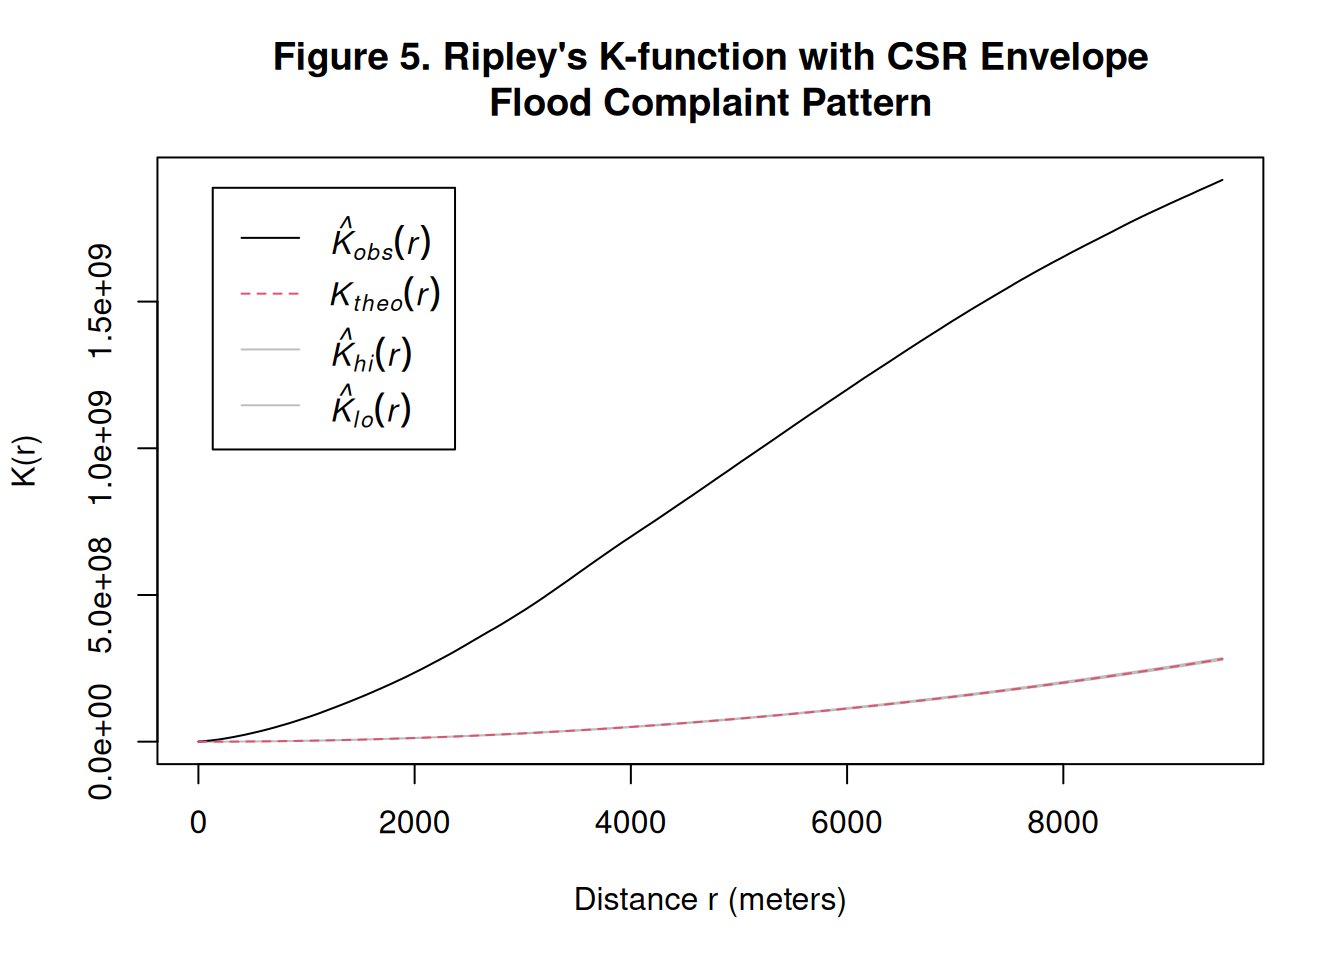

In [ ]:
library(spatstat.geom)
library(spatstat.explore)
library(spatstat.random)
library(sf)
library(dplyr)

flood_xy <- flood_events %>%
  transmute(
    x = longitude,
    y = latitude
  )

flood_sf <- st_as_sf(
  flood_xy,
  coords = c("x", "y"),
  crs = 3857,
  remove = FALSE
)

bbox_vals <- st_bbox(flood_sf)

if (any(is.na(bbox_vals))) {
  stop("Bounding box contains NA. Check coordinate values.")
}

ppp_flood <- as.ppp(flood_sf)

set.seed(123)
K_env <- envelope(
  ppp_flood,
  fun = Kest,
  nsim = 999,
  global = FALSE,
  correction = "Ripley"
)

# Initial Conclusion

The results from the Ripley’s K-function analysis provide strong evidence that flood-related complaints in Miami do **not** follow a Completely Spatially Random (CSR) process. Across nearly all distances, the observed K(r) curve lies **well above** the Monte Carlo CSR simulation envelope based on 999 simulated patterns. This pattern indicates statistically significant **clustering** of complaints, meaning flood complaints occur in localized hotspots rather than being evenly distributed across the city.

This clustering effect is most pronounced at mid-range distances (approximately 2–6 km), suggesting that infrastructure, drainage network performance, and local urban morphology may be contributing to spatial concentration of flood events.  
Overall, these results support the hypothesis that Miami’s flood complaints exhibit non-random spatial clustering.

## Roadmap for Further Exploration

The present analysis demonstrates clear spatial clustering of flood-related complaints, but several extensions could strengthen the interpretation:

1.  **Integrate Environmental Covariates.**  
    Incorporating elevation, land cover, population density, and drainage infrastructure could help separate first-order (intensity-driven) effects from true second-order interactions. For example, low-lying coastal zones may exhibit higher baseline intensity independent of clustering.

2.  **Use Temporal Information.**  
    The current dataset does not incorporate complaint dates. Adding time could reveal whether clustering varies during high tides, extreme rainfall events, or seasonal cycles.

3.  **Incorporate Hydrological or Tidal Data.**  
    Integrating NOAA tide-gauge data and rainfall records would allow testing whether environmental drivers amplify clustering patterns.

4.  **Higher-Resolution Window Definition.**  
    Refining the study window to explicit Miami neighborhood boundaries could yield more interpretable local patterns.

5.  **Alternative Second-Order Functions (PCF g(r)).**  
    Pair Correlation Function can provide finer-scale insights into clustering, especially at distances under 2 km.

Together, these steps form a roadmap for refined spatial inference and more confident evaluation of flood risk patterns in Miami.

### Figure 6: Pair Correlation Function (PCF)

Generating 999 simulations of CSR  ...
1, 2, 3, ......10 [6:15 remaining] .........20 [6:14 remaining] ...
......30 [6:14 remaining] .........40 [5:39 remaining] .........50 [5:23 remaining] ..
.......60 [5:21 remaining] .........70 [5:17 remaining] .........80 [5:41 remaining] .
........90 [5:23 remaining] .........100 [5:09 remaining] .........110
 [4:56 remaining] .........120 [4:45 remaining] .........130 [4:35 remaining] .........
140 [4:26 remaining] .........150 [4:18 remaining] .........160 [4:11 remaining] ........
.170 [4:05 remaining] .........180 [3:59 remaining] .........190 [3:54 remaining] .......
..200 [3:49 remaining] .........210 [3:48 remaining] .........220 [3:44 remaining] ......
...230 [3:42 remaining] .........240 [3:45 remaining] .........250 [3:41 remaining] .....
....260 [3:37 remaining] .........270 [3:33 remaining] .........280 [3:29 remaining] ....
.....290 [3:26 remaining] .........300 [3:22 remaining] .........310 [3:17 remaining] ...
......320 [3:13 rema

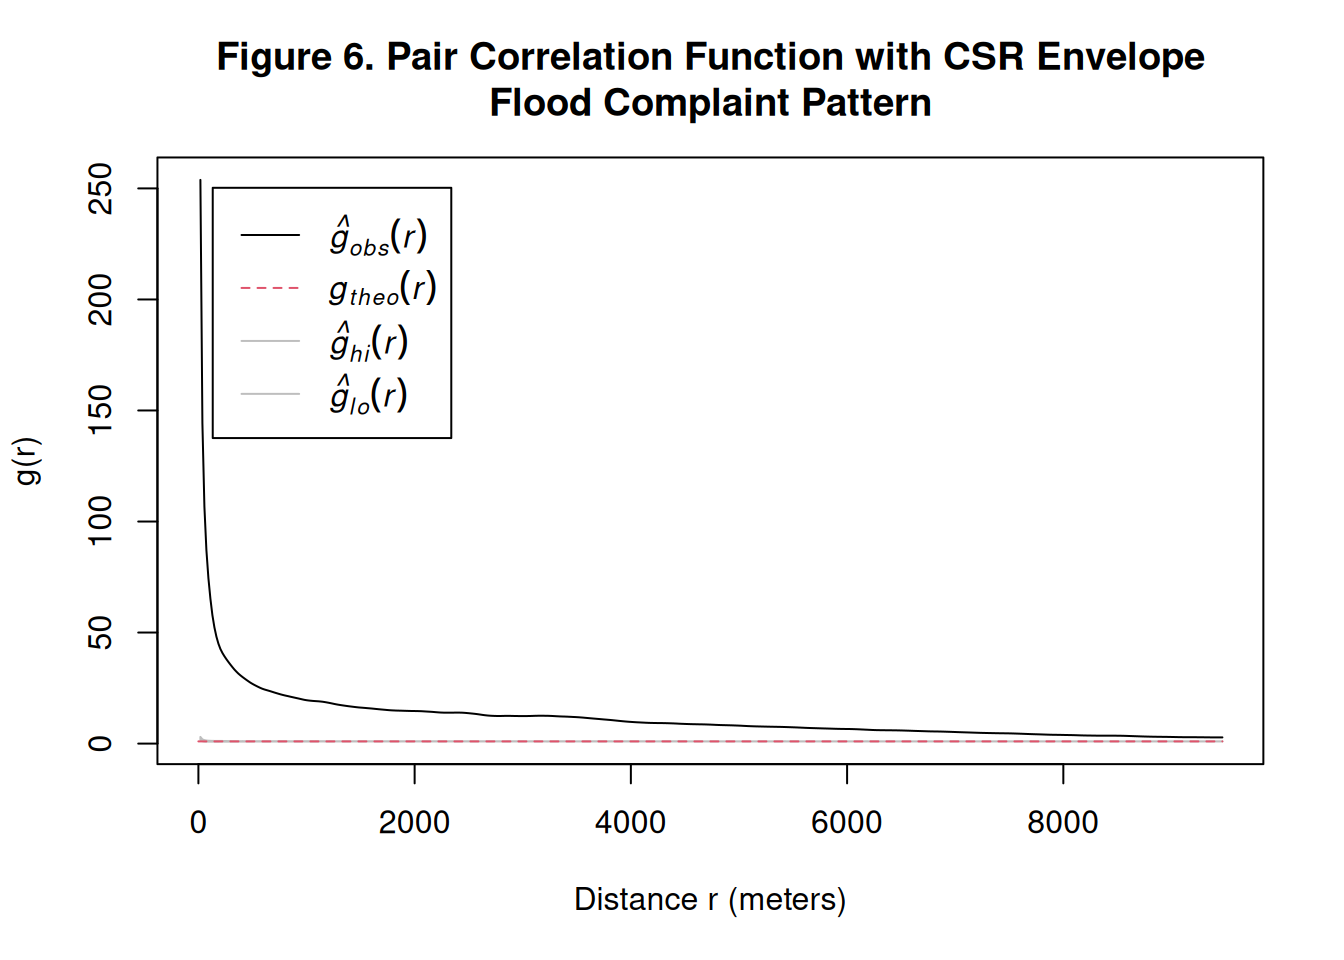

In [ ]:
library(spatstat.geom)
library(spatstat.explore)

pcf_env <- envelope(
  ppp_flood,
  fun = pcf,
  nsim = 999,
  correction = "Ripley",
  global = FALSE
)

The pair correlation function g(r) further confirms the strong clustering behavior identified in the K-function analysis. At very short distances (r \< 500 meters), g(r) is dramatically higher than 1 and far outside the CSR envelope, indicating intense local clustering of flood complaints.

As distance increases, g(r) gradually decreases toward 1 but remains above the CSR expectation for the majority of the spatial range. This reinforces that the pattern exhibits significant clustering across multiple spatial scales, rather than only a few isolated hotspots.

```` markdown
---
title: "Spatial Point Pattern Analysis of Flood Complaints in Miami, Florida"
author: "Hailun Ma"

execute:
  echo: true
  warning: false
  message: false
---

# Abstract
This project analyzes the spatial pattern of flood-related 311 complaints in Miami. 
Using point data from the City of Miami and elevation data from USGS, I explore 
whether these complaints are randomly distributed or if they form clusters across the 
city. After building exploratory maps, kernel density estimates, and conducting formal 
spatial tests including Ripley’s K-function and the Pair Correlation Function, the 
results show strong evidence of clustering. These findings suggest that certain 
neighborhoods consistently experience more flood issues, likely due to local 
infrastructure, elevation, and drainage conditions.

# Introduction

Urban flooding is a recurring problem in Miami, especially during heavy rainfall and 
king tide events. Residents often submit 311 complaints when streets or properties 
flood, which creates a useful dataset for understanding where flooding tends to happen. 
In this project, I focus on flood-related 311 complaints to answer a simple question:

**Are Miami’s flood complaints randomly distributed across the city, or do they form 
clusters in specific neighborhoods?**

To answer this, I use several tools from spatial data science, including exploratory 
mapping, kernel density estimation, and formal second-order spatial statistics.  
These methods allow me to evaluate both the overall intensity of the events and the 
underlying spatial interaction between points. The goal is to understand whether the 
pattern reflects random noise or meaningful spatial structure.

---

# Literature Review

Flooding patterns in coastal cities often reflect a combination of environmental conditions (such as elevation and proximity to the coastline) and built infrastructure (storm drains, road design, land cover). Prior research shows that:

- Low elevations and tidal influences increase vulnerability.  
- Urban hydrology can produce recurring flood “hotspots.”  
- Spatial point pattern methods, including K-function and PCF, are widely used for identifying clustering in crime, disease, and environmental hazards.

However, fewer studies examine **urban flood complaints** using these methods, even though 311 data provide highly localized, real-time information. This project adds to the literature by applying spatial statistics to understand Miami’s flood experience from the perspective of residents.

---

# Data
This project uses two main datasets:

1. **311 flood-related complaints in Miami (CSV)**  
   The dataset includes the location of each complaint (longitude and latitude), the 
   type of issue, a short description, and the date the ticket was created.  
   I cleaned the dataset by selecting only complaints related to flooding and by 
   converting the coordinates into a projected CRS (EPSG:3857) for spatial analysis.

2. **USGS Digital Elevation Model (GeoTIFF)**  
   Elevation is used to understand the terrain and visually compare low-lying regions 
   with clusters of complaints. The raster was reprojected and plotted together with 
   the complaint points.

Together, these datasets allow both first-order (intensity-based) and second-order 
(interaction-based) spatial analysis.

# Methods
### Exploratory Mapping  
I first plotted the raw points to get a general sense of where complaints occur.  
I also created an interactive map and a heatmap, which both suggested that the 
complaints concentrate around the Coral Gables–Miami Beach area.

### Kernel Density Estimation (First-order Analysis)  
I used a kernel density estimate (KDE) to examine the intensity of events across 
Miami. This shows where complaints are more frequent without making any assumptions 
about spatial interaction.

### Ripley’s K-function (Second-order Analysis)  
To formally test whether the pattern is clustered or random, I computed Ripley’s 
K-function and compared it to 999 simulated patterns generated under the assumption 
of Complete Spatial Randomness (CSR).  
If the observed curve is above the CSR envelope, this indicates clustering.

### Pair Correlation Function 
The PCF is a related second-order tool that focuses specifically on short-range 
interactions. It is especially helpful for detecting clustering within the first 
few hundred meters. Like the K-function, I generated 999 simulations to form a CSR 
envelope for comparison.


quarto-executable-code-5450563D

```r
library(readr)
library(dplyr)
library(sf)
library(terra)
library(ggplot2)
library(leaflet)

library(spatstat.geom)
library(spatstat.explore)
library(spatstat.random)
library(MASS)     


#| label: load-data
flood_events <- read_csv("output_data/flood_events_miami.csv")
glimpse(flood_events)
```

### Figure 1. Study Area Map (Boundary + Points)

quarto-executable-code-5450563D

```r
library(readr)
library(sf)
library(ggplot2)
library(dplyr)

flood_events <- read_csv("output_data/flood_events_miami.csv")

flood_points_sf <- st_as_sf(
  flood_events,
  coords = c("longitude", "latitude"),
  crs = 3857
)

flood_coords <- flood_points_sf %>% 
  st_coordinates() %>% 
  as.data.frame()

bbox <- st_bbox(flood_points_sf)

bbox_poly <- data.frame(
  x = c(bbox["xmin"], bbox["xmax"], bbox["xmax"], bbox["xmin"], bbox["xmin"]),
  y = c(bbox["ymin"], bbox["ymin"], bbox["ymax"], bbox["ymax"], bbox["ymin"])
)

ggplot() +
  geom_polygon(
    data = bbox_poly,
    aes(x = x, y = y),
    fill = NA,
    color = "black",
    linewidth = 0.7
  ) +
  geom_point(
    data = flood_coords,
    aes(x = X, y = Y),
    color = "#1f78b4",
    alpha = 0.7,
    size = 0.4
  ) +
  theme_minimal() +
  labs(
    title = "Study Area: Miami Flood Complaints",
    subtitle = "Analysis window and 311 flood-related events",
    x = "Easting (m, EPSG:3857)",
    y = "Northing (m, EPSG:3857)"
  )
```
## Elevation Context (First-Order Pattern)

Understanding whether flood-related 311 complaints occur preferentially in
low-lying areas is a first-order spatial question. To explore this, elevation
data for Miami (USGS DEM) were visualized alongside the point pattern of flood
complaints. If lower-elevation zones show visibly higher concentrations of
points, this would provide initial evidence of an underlying first-order
intensity gradient driven by topography.

### Figure 2. Elevation Raster Overlaid with Flood Complaints

Areas of lower elevation appear to contain denser clusters of flood-related
complaints. This visual pattern suggests the possibility of a first-order
intensity variation driven by elevation, which motivates the formal
hypothesis-testing steps that follow.

quarto-executable-code-5450563D

```r
library(terra)
library(sf)
library(ggplot2)
library(dplyr)

dem <- rast("output_data/miami_florida.tif")

dem_df <- as.data.frame(dem, xy = TRUE, na.rm = TRUE)
names(dem_df)[3] <- "elev"

flood_points_dem <- st_transform(flood_points_sf, crs(dem))
flood_coords_dem <- st_coordinates(flood_points_dem) |> as.data.frame()

ggplot() +
  geom_raster(
    data = dem_df,
    aes(x = x, y = y, fill = elev)
  ) +
  scale_fill_viridis_c(name = "Elevation (m)", option = "C") +
  geom_point(
    data = flood_coords_dem,
    aes(x = X, y = Y),
    color = "red",
    size = 0.4,
    alpha = 0.7
  ) +
  theme_minimal() +
  labs(
    title = "Elevation and Flood Complaints in Miami",
    subtitle = "USGS digital elevation model with 311 flood-related complaint points",
    x = NULL, y = NULL
  )
```

### Figure 3. Interactive Map of 311 Flood Complaints

This interactive map provides an initial look at the raw spatial distribution
of flood-related complaints across Miami. Visual inspection suggests clustering
in specific neighborhoods, especially in low-lying coastal areas.
quarto-executable-code-5450563D

```r
flood_events_ll <- flood_events |>
  st_as_sf(coords = c("longitude", "latitude"), crs = 3857) |>
  st_transform(4326) |>
  mutate(
    lon = st_coordinates(geometry)[,1],
    lat = st_coordinates(geometry)[,2]
  )

leaflet(flood_events_ll) |>
  addProviderTiles("CartoDB.Positron") |>
  addCircleMarkers(
    lng = ~lon,
    lat = ~lat,
    radius = 3,
    stroke = FALSE,
    fillOpacity = 0.5,
    popup = ~paste0(
      "<b>Type: </b>", issue_type, "<br>",
      "<b>Description: </b>", issue_Description, "<br>",
      "<b>Created: </b>", ticket_created_date_time
    )
  )
```

### Figure 4. Interactive Kernel Density Heatmap of Flood Complaints

To explore first-order spatial variation in complaint density, a simple
interactive heatmap was generated using a Gaussian kernel. This visualization
highlights areas with higher concentrations of flood-related 311 complaints,
with dense blue regions indicating potential hotspots of flooding issues.
quarto-executable-code-5450563D

```r
library(leaflet)
library(leaflet.extras)

flood_events_ll <- flood_events |>
  st_as_sf(coords = c("longitude", "latitude"), crs = 3857) |>
  st_transform(4326) |>
  mutate(
    lon = st_coordinates(geometry)[,1],
    lat = st_coordinates(geometry)[,2]
  )

leaflet(flood_events_ll) |>
  addProviderTiles("CartoDB.Positron") |>
  addHeatmap(
    lng = ~lon,
    lat = ~lat,
    blur = 20,
    max = 0.05,
    radius = 15
  )
```

## Second-Order Pattern: Ripley’s K-function

To test whether the flood complaints exhibit clustering beyond what would be
expected under complete spatial randomness (CSR), I computed Ripley’s
K-function for the observed point pattern and compared it to a Monte-Carlo
envelope generated under CSR. If the observed K(r) lies above the upper
envelope, this indicates statistically significant clustering at distance r;
values below the lower envelope would instead indicate inhibition or regular
spacing.


### Figure 5. Ripley’s K-function with CSR Envelope

Figure 5 compares the empirical K-function of flood complaints against a
Monte-Carlo envelope under CSR. Across most spatial scales, the observed
K(r) curve lies well above the upper envelope, indicating that flood-related
complaints are more clustered than expected from a homogeneous Poisson
process. This provides formal second-order evidence of spatial clustering.

```{r k_function, message=FALSE, warning=FALSE}
library(spatstat.geom)
library(spatstat.explore)
library(spatstat.random)
library(sf)
library(dplyr)

flood_xy <- flood_events %>%
  transmute(
    x = longitude,
    y = latitude
  )

flood_sf <- st_as_sf(
  flood_xy,
  coords = c("x", "y"),
  crs = 3857,
  remove = FALSE
)

bbox_vals <- st_bbox(flood_sf)

if (any(is.na(bbox_vals))) {
  stop("Bounding box contains NA. Check coordinate values.")
}

ppp_flood <- as.ppp(flood_sf)

set.seed(123)
K_env <- envelope(
  ppp_flood,
  fun = Kest,
  nsim = 999,
  global = FALSE,
  correction = "Ripley"
)

plot(
  K_env,
  main = "Figure 5. Ripley's K-function with CSR Envelope\nFlood Complaint Pattern",
  xlab = "Distance r (meters)",
  ylab = "K(r)"
)
```

# Initial Conclusion

The results from the Ripley’s K-function analysis provide strong evidence that 
flood-related complaints in Miami do **not** follow a Completely Spatially Random (CSR) 
process. Across nearly all distances, the observed K(r) curve lies **well above** the 
Monte Carlo CSR simulation envelope based on 999 simulated patterns. This pattern 
indicates statistically significant **clustering** of complaints, meaning flood complaints 
occur in localized hotspots rather than being evenly distributed across the city.

This clustering effect is most pronounced at mid-range distances (approximately 
2–6 km), suggesting that infrastructure, drainage network performance, and local 
urban morphology may be contributing to spatial concentration of flood events.  
Overall, these results support the hypothesis that Miami’s flood complaints exhibit 
non-random spatial clustering.

## Roadmap for Further Exploration

The present analysis demonstrates clear spatial clustering of flood-related 
complaints, but several extensions could strengthen the interpretation:

1. **Integrate Environmental Covariates.**  
   Incorporating elevation, land cover, population density, and drainage infrastructure 
   could help separate first-order (intensity-driven) effects from true second-order 
   interactions. For example, low-lying coastal zones may exhibit higher baseline 
   intensity independent of clustering.

2. **Use Temporal Information.**  
   The current dataset does not incorporate complaint dates. Adding time could reveal 
   whether clustering varies during high tides, extreme rainfall events, or seasonal 
   cycles.

3. **Incorporate Hydrological or Tidal Data.**  
   Integrating NOAA tide-gauge data and rainfall records would allow testing whether 
   environmental drivers amplify clustering patterns.

4. **Higher-Resolution Window Definition.**  
   Refining the study window to explicit Miami neighborhood boundaries could yield 
   more interpretable local patterns.

5. **Alternative Second-Order Functions (PCF g(r)).**  
   Pair Correlation Function can provide finer-scale insights into clustering, especially 
   at distances under 2 km.

Together, these steps form a roadmap for refined spatial inference and more confident 
evaluation of flood risk patterns in Miami.

### Figure 6: Pair Correlation Function (PCF)
quarto-executable-code-5450563D

```r
library(spatstat.geom)
library(spatstat.explore)

pcf_env <- envelope(
  ppp_flood,
  fun = pcf,
  nsim = 999,
  correction = "Ripley",
  global = FALSE
)

plot(
  pcf_env,
  main = "Figure 6. Pair Correlation Function with CSR Envelope\nFlood Complaint Pattern",
  xlab = "Distance r (meters)",
  ylab = "g(r)"
)

```
The pair correlation function g(r) further confirms the strong clustering behavior 
identified in the K-function analysis. At very short distances (r < 500 meters), 
g(r) is dramatically higher than 1 and far outside the CSR envelope, indicating 
intense local clustering of flood complaints. 

As distance increases, g(r) gradually decreases toward 1 but remains above the CSR 
expectation for the majority of the spatial range. This reinforces that the pattern 
exhibits significant clustering across multiple spatial scales, rather than only 
a few isolated hotspots.
````